In [12]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from custom_gmm import EnhancedGMM

In [13]:
### Step 1: Data Collection
print("Fetching S&P 500 data...")
stock = yf.download('^GSPC', start='2019-01-01', end='2024-01-01')
stock = stock[['Close']]  # Retain only closing prices
print(f"Data fetched: {stock.shape[0]} days of closing prices.")

[*********************100%***********************]  1 of 1 completed

Fetching S&P 500 data...
Data fetched: 1258 days of closing prices.


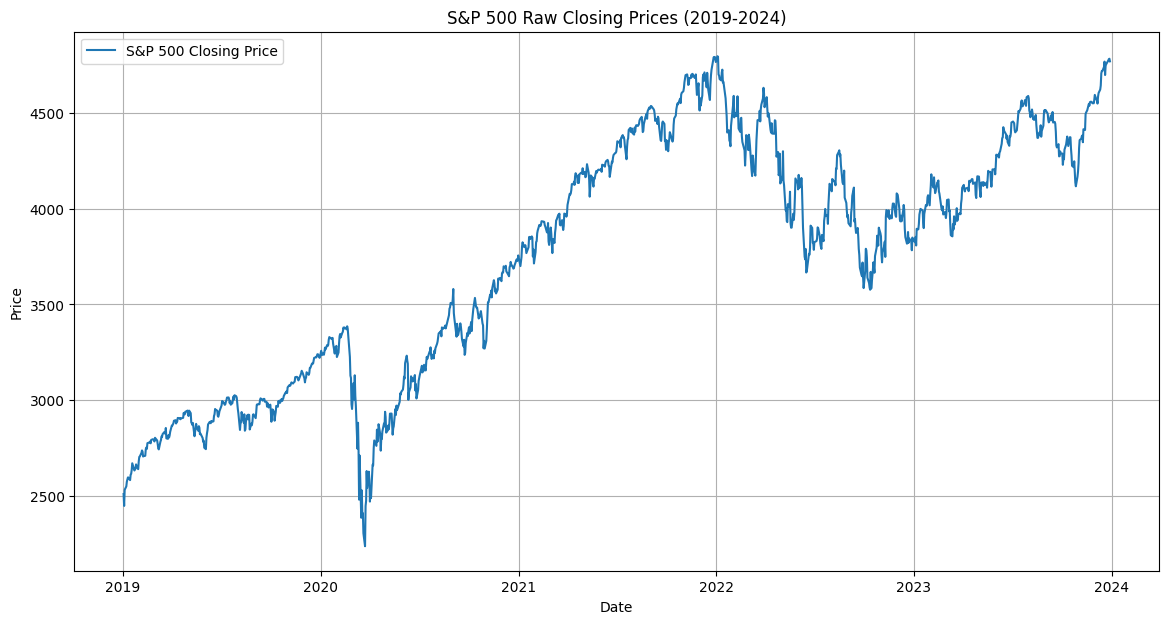

In [14]:
# Create figure for raw downloaded data
fig1 = plt.figure(figsize=(14, 7))
plt.plot(stock.index, stock['Close'], label='S&P 500 Closing Price')
plt.title('S&P 500 Raw Closing Prices (2019-2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

In [15]:
# Display first few rows of raw data as table
print("\nRaw S&P 500 Data (First 10 rows):")
print(stock.head(10).to_string())


Raw S&P 500 Data (First 10 rows):
Price             Close
Ticker            ^GSPC
Date                   
2019-01-02  2510.030029
2019-01-03  2447.889893
2019-01-04  2531.939941
2019-01-07  2549.689941
2019-01-08  2574.409912
2019-01-09  2584.959961
2019-01-10  2596.639893
2019-01-11  2596.260010
2019-01-14  2582.610107
2019-01-15  2610.300049


In [16]:
### Step 2: Feature Engineering
# Calculate daily returns
stock['Return'] = stock['Close'].pct_change()

# Calculate 5-day rolling volatility
stock['Volatility'] = stock['Return'].rolling(window=5).std()

# Remove rows with NaN values
stock = stock.dropna()
print(f"\nFeatures engineered: {stock.shape[0]} days with returns and volatility.")

# Display processed data as table
print("\nProcessed Data with Features (First 10 rows):")
print(stock[['Close', 'Return', 'Volatility']].head(10).to_string())

# Prepare feature array for clustering
features = stock[['Return', 'Volatility']].values


Features engineered: 1253 days with returns and volatility.

Processed Data with Features (First 10 rows):
Price             Close    Return Volatility
Ticker            ^GSPC                     
Date                                        
2019-01-09  2584.959961  0.004098   0.021019
2019-01-10  2596.639893  0.004518   0.012723
2019-01-11  2596.260010 -0.000146   0.003661
2019-01-14  2582.610107 -0.005258   0.005602
2019-01-15  2610.300049  0.010722   0.005937
2019-01-16  2616.100098  0.002222   0.005893
2019-01-17  2635.959961  0.007591   0.006313
2019-01-18  2670.709961  0.013183   0.007365
2019-01-22  2632.899902 -0.014157   0.010900
2019-01-23  2638.699951  0.002203   0.010213


In [17]:
### Step 3: Model Implementation
# Initialize and fit enhanced GMM with 3 clusters
print("\nFitting Enhanced Gaussian Mixture Model...")
gmm = EnhancedGMM(n_components=3, max_iter=200, tol=1e-4, random_state=42, verbose=True)
gmm.fit(features)

# Predict cluster labels for each day
labels = gmm.predict(features)

# Add cluster labels to the dataframe
stock['Cluster'] = labels
print("\nClustering completed.")


Fitting Enhanced Gaussian Mixture Model...
Iteration 0: Log Likelihood = 8082.7117
Iteration 10: Log Likelihood = 8731.5636
Iteration 20: Log Likelihood = 8730.6999
Iteration 30: Log Likelihood = 8730.5191
Iteration 40: Log Likelihood = 8730.4579
Iteration 50: Log Likelihood = 8730.4172
Iteration 60: Log Likelihood = 8730.3850
Iteration 70: Log Likelihood = 8730.3592
Iteration 80: Log Likelihood = 8730.3384
Iteration 90: Log Likelihood = 8730.3218
Iteration 100: Log Likelihood = 8730.3085
Iteration 110: Log Likelihood = 8730.2980
Iteration 120: Log Likelihood = 8730.2896
Iteration 130: Log Likelihood = 8730.2829
Iteration 140: Log Likelihood = 8730.2776
Iteration 150: Log Likelihood = 8730.2735
Iteration 160: Log Likelihood = 8730.2702
Iteration 170: Log Likelihood = 8730.2676
Iteration 180: Log Likelihood = 8730.2655
Iteration 190: Log Likelihood = 8730.2639

Clustering completed.


In [18]:
### Step 4: Trend Definition
# Compute mean return for each cluster
cluster_means = stock.groupby('Cluster')['Return'].mean()
print("\nCluster Mean Returns:")
print(cluster_means)

# Define trend labels based on mean returns
trend_labels = {
    cluster_means.idxmax(): 'Uptrend',
    cluster_means.idxmin(): 'Downtrend',
    cluster_means.index[~cluster_means.index.isin([cluster_means.idxmax(), cluster_means.idxmin()])][0]: 'Neutral'
}

# Map clusters to trend labels
stock['Trend'] = stock['Cluster'].map(trend_labels)
print("\nTrend assignments:")
print(stock['Trend'].value_counts())


Cluster Mean Returns:
Cluster
0   -0.010236
1    0.004990
2   -0.002089
Name: Return, dtype: float64

Trend assignments:
Trend
Uptrend      848
Downtrend    326
Neutral       79
Name: count, dtype: int64


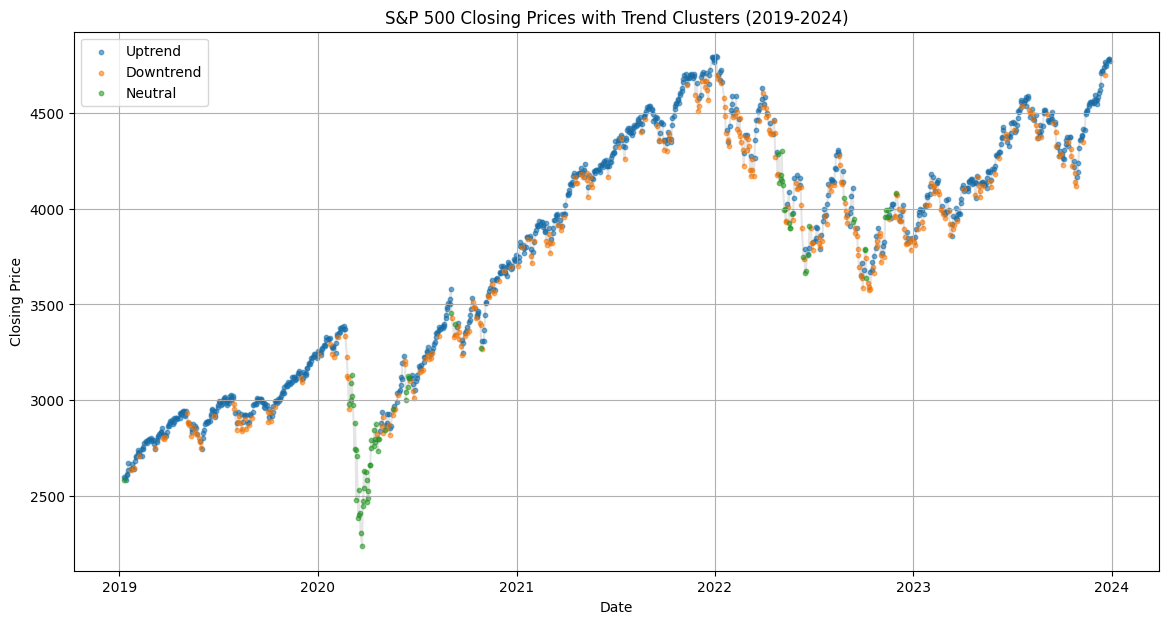

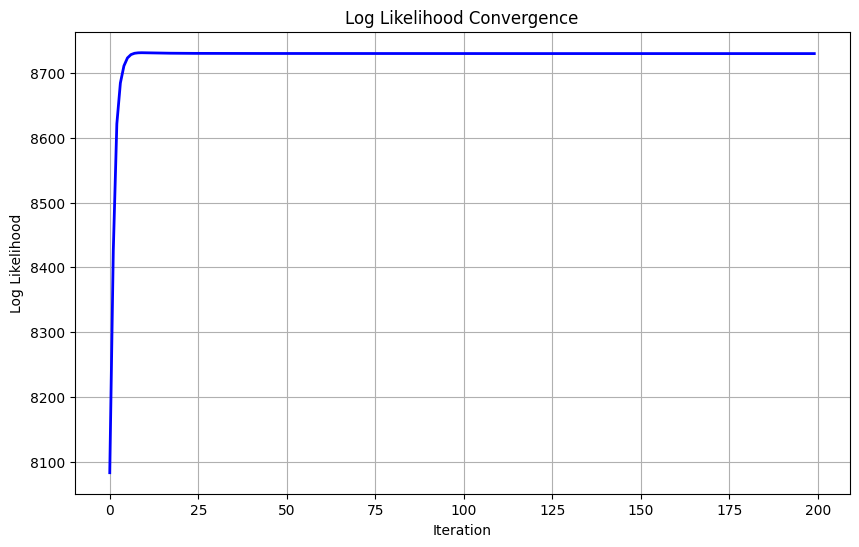

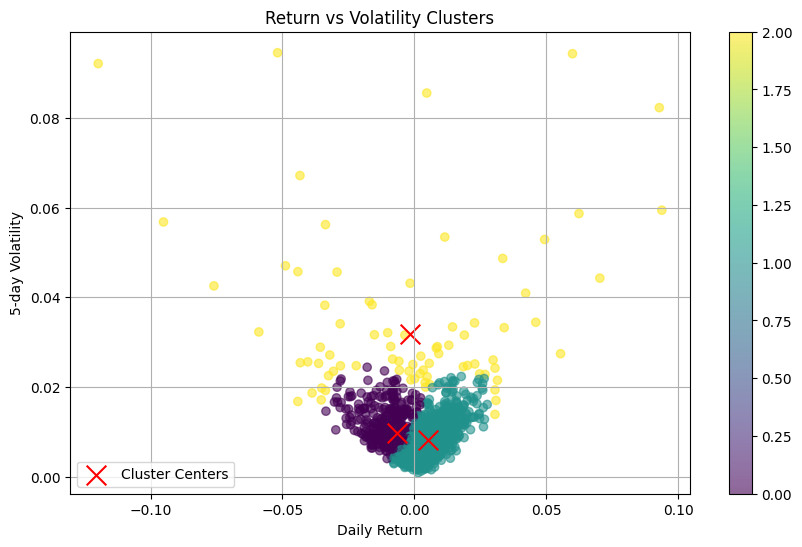

In [19]:
### Step 5: Evaluation and Visualization
# Create figure for closing prices with trend clusters
fig2 = plt.figure(figsize=(14, 7))
for trend in trend_labels.values():
    subset = stock[stock['Trend'] == trend]
    plt.scatter(subset.index, subset['Close'], label=trend, s=10, alpha=0.6)
plt.plot(stock.index, stock['Close'], 'k-', alpha=0.1)  # Add price line for context
plt.title('S&P 500 Closing Prices with Trend Clusters (2019-2024)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Create figure for convergence plot (modify EnhancedGMM's plot_convergence to return figure)
fig3 = plt.figure(figsize=(10, 6))
plt.plot(range(gmm.n_iter_), gmm.log_likelihood_history, 'b-', linewidth=2)
plt.title('Log Likelihood Convergence')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.grid(True)

# Create figure for features in 2D space
fig4 = plt.figure(figsize=(10, 6))
scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.title('Return vs Volatility Clusters')
plt.xlabel('Daily Return')
plt.ylabel('5-day Volatility')
plt.colorbar(scatter)
plt.legend()
plt.grid(True)

In [20]:
### Step 6: Performance Metrics
# Calculate alignment with actual price movement
stock['Price Direction'] = np.sign(stock['Return'])
stock['Trend Direction'] = stock['Trend'].map({'Uptrend': 1, 'Downtrend': -1, 'Neutral': 0})
alignment = (stock['Price Direction'] == stock['Trend Direction']).mean()
print(f"\nAlignment with actual price direction: {alignment:.2%}")

# Additional performance metrics
print("\nModel Performance Metrics:")
print(f"Converged: {gmm.converged_}")
print(f"Number of iterations: {gmm.n_iter_}")
print(f"Final log likelihood: {gmm.log_likelihood_history[-1]:.4f}")

# Calculate silhouette-like score (simplified)
def simplified_silhouette_score(X, labels):
    unique_labels = np.unique(labels)
    silhouette_vals = []
    for i in range(len(X)):
        same_cluster = X[labels == labels[i]]
        other_clusters = [X[labels == l] for l in unique_labels if l != labels[i]]
        a = np.mean([np.linalg.norm(X[i] - x) for x in same_cluster]) if len(same_cluster) > 1 else 0
        b = min([np.mean([np.linalg.norm(X[i] - x) for x in cluster])
                for cluster in other_clusters if len(cluster) > 0]) if other_clusters else 0
        silhouette_vals.append((b - a) / max(a, b) if max(a, b) > 0 else 0)
    return np.mean(silhouette_vals)

silhouette = simplified_silhouette_score(features, labels)
print(f"Simplified Silhouette Score: {silhouette:.4f}")

# Display final data table with clusters
print("\nFinal Data with Clusters (All Rows):")
# Format the DataFrame for tabulate
table_data = stock[['Close', 'Return', 'Volatility', 'Cluster', 'Trend']].reset_index()
# Convert to a list of lists for tabulate
table_data = table_data.values.tolist()
headers = ['Date', 'Close', 'Return', 'Volatility', 'Cluster', 'Trend']
print(tabulate(table_data, headers=headers, tablefmt='pretty', floatfmt='.6f'))


Alignment with actual price direction: 75.90%

Model Performance Metrics:
Converged: False
Number of iterations: 200
Final log likelihood: 8730.2627
Simplified Silhouette Score: 0.3726

Final Data with Clusters (All Rows):
+---------------------+-------------------+-------------------------+-----------------------+---------+-----------+
|        Date         |       Close       |         Return          |      Volatility       | Cluster |   Trend   |
+---------------------+-------------------+-------------------------+-----------------------+---------+-----------+
| 2019-01-09 00:00:00 |  2584.9599609375  |  0.004098045450532162   | 0.021018762038652723  |    2    |  Neutral  |
| 2019-01-10 00:00:00 | 2596.639892578125 |  0.004518418782931244   | 0.012722845168000641  |    1    |  Uptrend  |
| 2019-01-11 00:00:00 | 2596.260009765625 | -0.00014629784190933748 | 0.0036609830131879477 |    1    |  Uptrend  |
| 2019-01-14 00:00:00 | 2582.610107421875 |  -0.005257525167898014  | 0.00560242

In [21]:
# Save figures to files
stock[['Close', 'Return', 'Volatility', 'Cluster', 'Trend']].to_csv('cluster_data.csv')
print("\nFull data saved to 'cluster_data.csv'")


# Save all cluster data to Excel
excel_file = 'sp500_cluster_data.xlsx'
print(f"\nSaving all cluster data to '{excel_file}'...")
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    stock[['Close', 'Return', 'Volatility', 'Cluster', 'Trend']].to_excel(writer, sheet_name='Cluster Data', index=True)
print(f"Data successfully saved to '{excel_file}'")

# Show all figures at once
plt.show()


Full data saved to 'cluster_data.csv'

Saving all cluster data to 'sp500_cluster_data.xlsx'...
Data successfully saved to 'sp500_cluster_data.xlsx'
